In [116]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

In [117]:
df = pd.read_csv('Gia SMP va SMPcap 2021(Giá thị trường SMP).csv', encoding="latin-1", delimiter=';')
df= df.set_index('Ngày')

In [118]:
data = df[['2','3','4']]
data

,2,3,4
Ngày,,,
01/01/2021,964.4,964.4,964.4
01/02/2021,1019.7,1019.7,1019.7
01/03/2021,988.4,988.4,988.4
01/04/2021,1002.0,1002.0,1002.0
01/05/2021,1061.5,1061.5,1061.5
...,...,...,...
27/12/2021,1002.0,1002.0,1002.0
28/12/2021,1002.0,1002.0,1002.0
29/12/2021,1061.5,1061.5,1061.5


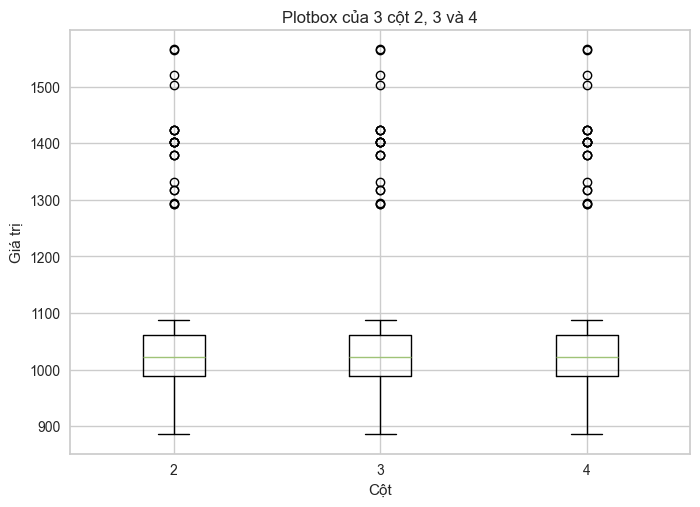

In [119]:
plt.boxplot([data['2'], data['3'], data['4']], labels=['2', '3','4'])
plt.xlabel('Cột')
plt.ylabel('Giá trị')
plt.title('Plotbox của 3 cột 2, 3 và 4')
plt.show()

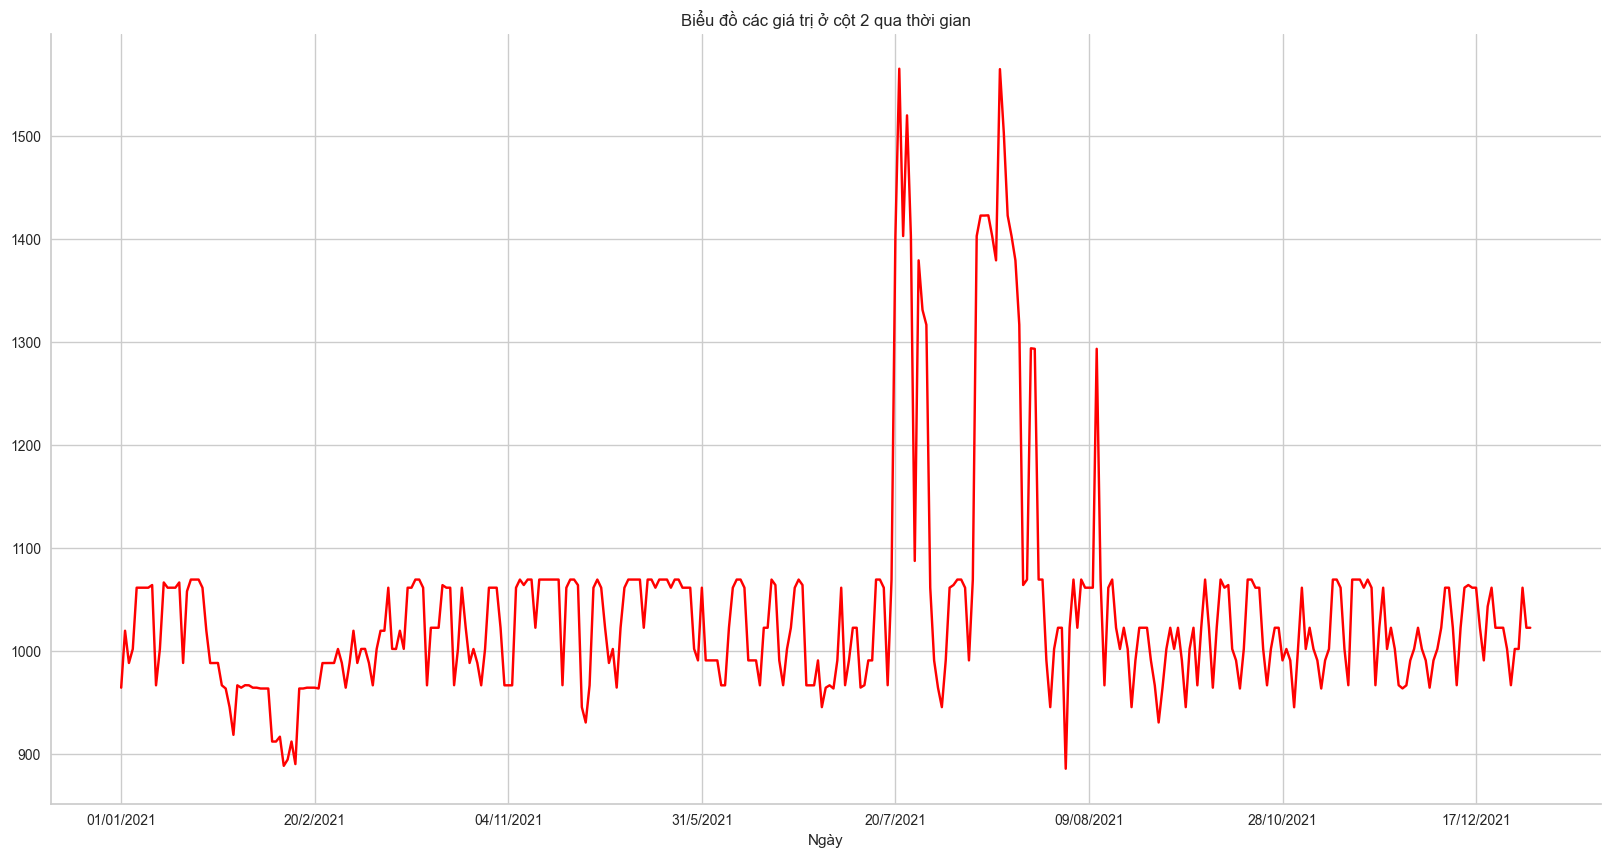

In [120]:
plt.figure(figsize=(20,10))
df['2'].plot(kind = 'line',title="Biểu đồ các giá trị ở cột 2 qua thời gian", color='red')
plt.gca().spines[['top','right']].set_visible(False)

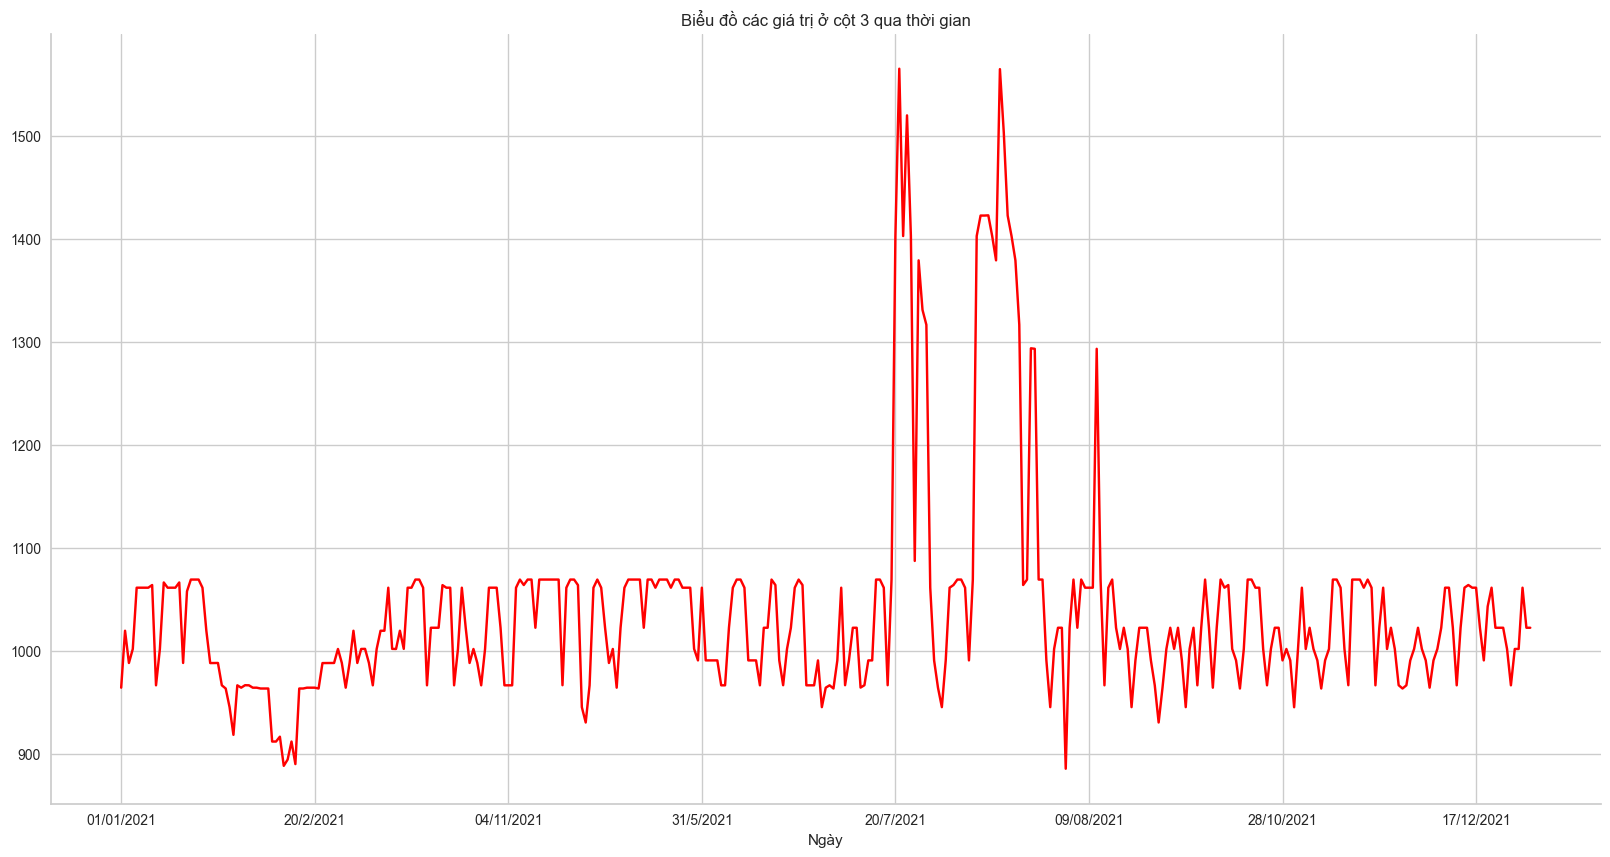

In [121]:
plt.figure(figsize=(20,10))
df['3'].plot(kind = 'line',title="Biểu đồ các giá trị ở cột 3 qua thời gian", color='red')
plt.gca().spines[['top','right']].set_visible(False)

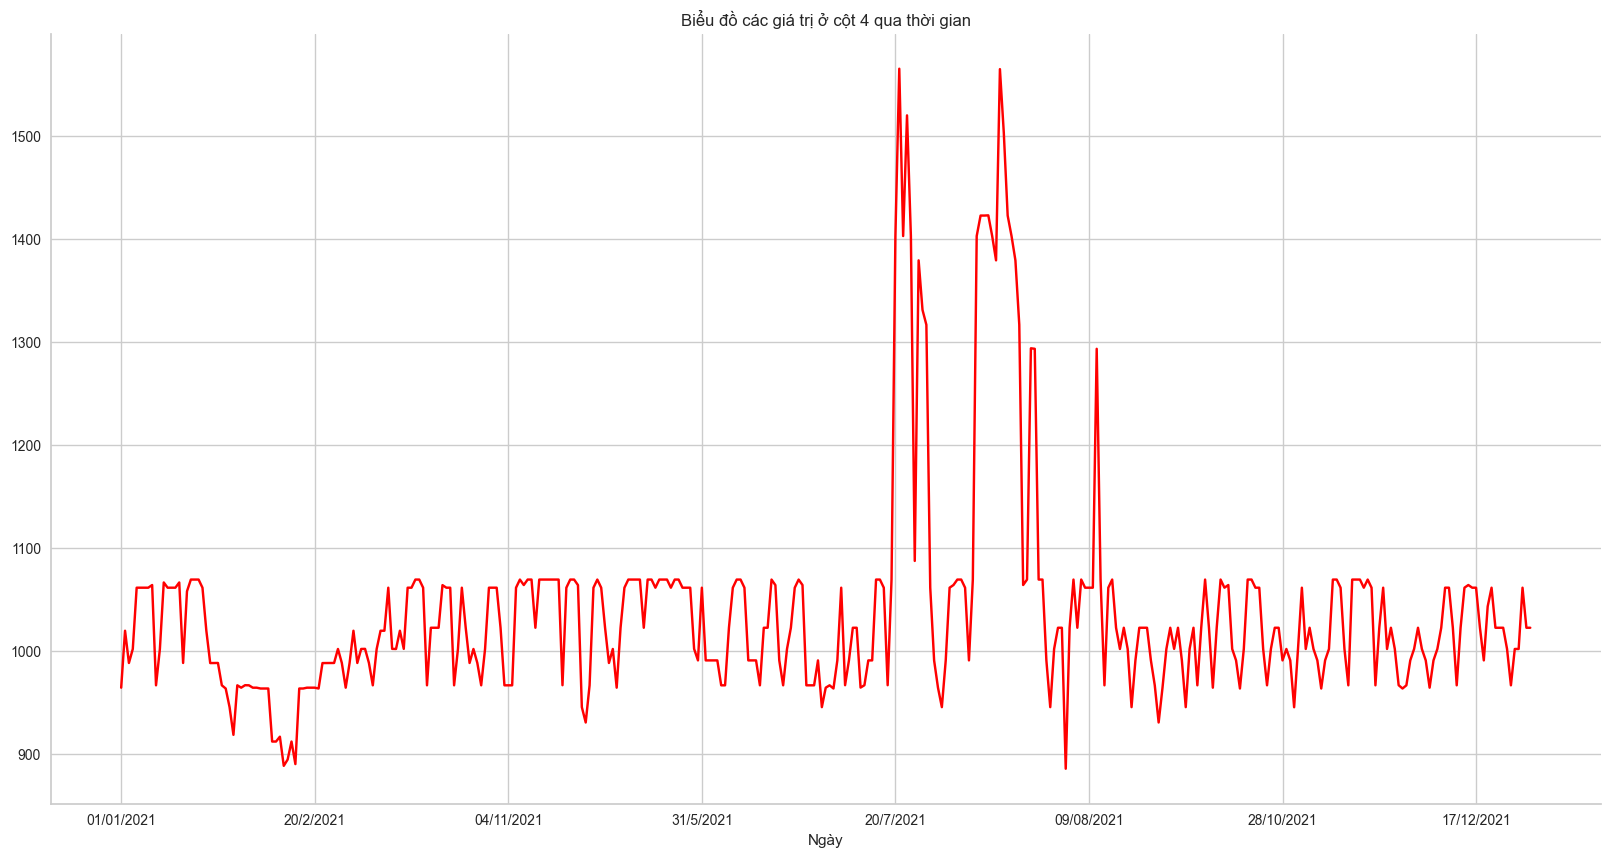

In [122]:
plt.figure(figsize=(20,10))
df['4'].plot(kind = 'line',title="Biểu đồ các giá trị ở cột 4 qua thời gian", color='red')
plt.gca().spines[['top','right']].set_visible(False)

ScatterMatrix

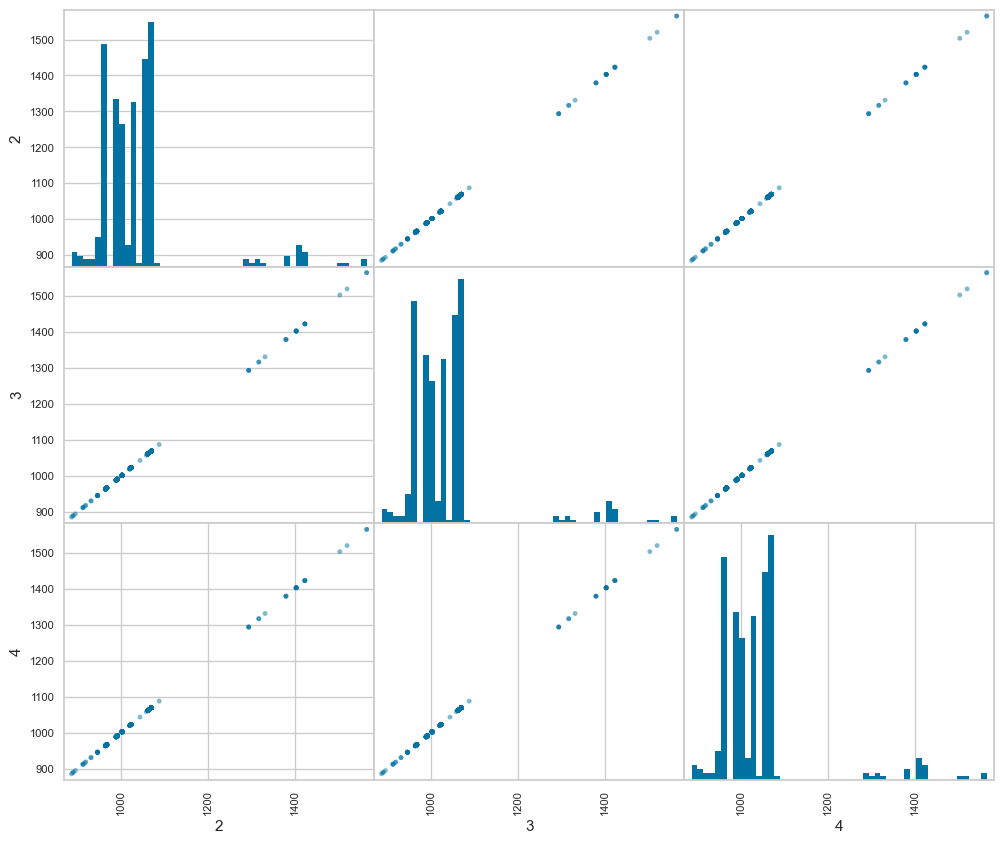

In [123]:
from pandas.plotting import scatter_matrix

columns = ["2", "3", "4"]
scatter_matrix(df[columns], figsize=(12,10), hist_kwds={'bins': 50});

Kalman

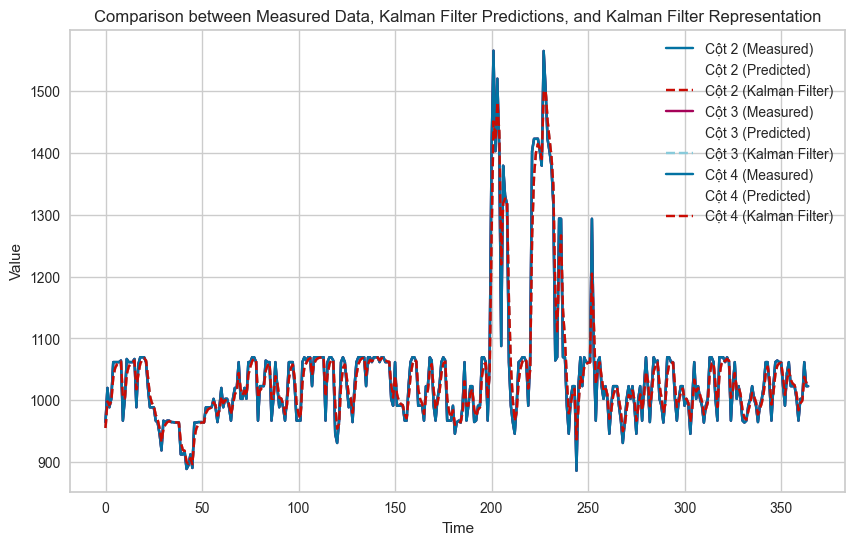

In [124]:
from pykalman import KalmanFilter
import numpy as np

data = np.array(data)

kf = KalmanFilter(
    initial_state_mean=np.zeros(3),  # Giả sử trạng thái ban đầu là [0, 0, 0]
    initial_state_covariance=np.eye(3),
    observation_matrices=np.eye(3),  # Mỗi biến trạng thái đều được quan sát trực tiếp
    observation_covariance=np.eye(3) * 0.01,  # Ma trận hiệp phương sai của quá trình đo lường
    transition_matrices=np.eye(3),  # Không có sự thay đổi trong trạng thái
    transition_covariance=np.eye(3) * 0.01,  # Ma trận hiệp phương sai của quá trình dự báo
)

# Áp dụng filter lên dữ liệu để ước lượng trạng thái
state_means, _ = kf.filter(data)

predicted_state_means, _ = kf.filter_update(state_means[-1], kf.transition_covariance)

plt.figure(figsize=(10, 6))
for i in range(3):  # Vẽ từng biến trạng thái
    plt.plot(data[:, i], label=f'Cột {i+2} (Measured)')
    plt.plot(range(len(data), len(data) + 1), predicted_state_means[i], 'x', label=f'Cột {i+2} (Predicted)')
    plt.plot(state_means[:, i], label=f'Cột {i+2} (Kalman Filter)', linestyle='--')  # Đường biểu diễn của Kalman Filter
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Comparison between Measured Data, Kalman Filter Predictions, and Kalman Filter Representation')
plt.legend()
plt.grid(True)
plt.show()

GaussianMixture

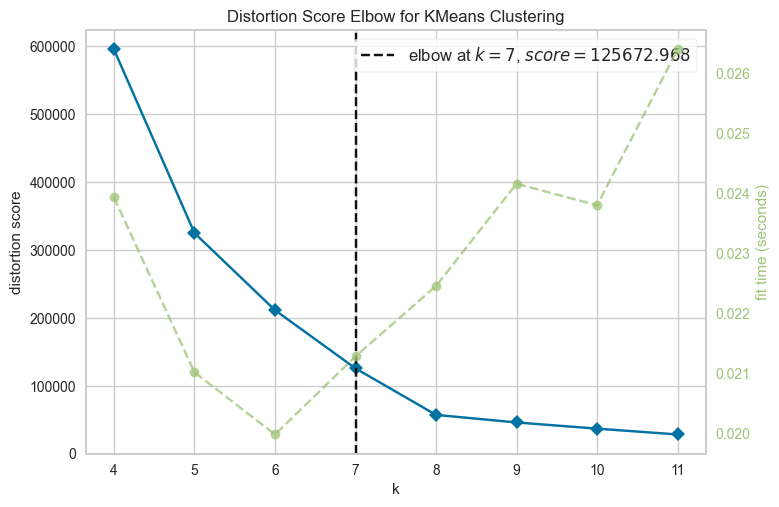

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [125]:
from yellowbrick.cluster import KElbowVisualizer
Elbow_M = KElbowVisualizer(KMeans(random_state=27, n_init=10), k=(4,12))
Elbow_M.fit(data)
Elbow_M.show()

In [126]:
GM = GaussianMixture(n_components=8)

preds_gm = GM.fit_predict(data)

In [127]:
pp=GM.predict_proba(data)# Calcualting the probabilities of each prediction
df_new=pd.DataFrame(data) 
df_new[[f'predict_proba_{i}' for i in range(8)]]=pp # creating new dataframe columns of probabilites 
df_new['preds']=preds_gm
df_new['predict_proba']=np.max(pp,axis=1)
df_new['predict']=np.argmax(pp,axis=1)
    
train_index=np.array([])
for n in range(8):
    n_inx=df_new[(df_new.preds==n) & (df_new.predict_proba > 0.68)].index
    train_index = np.concatenate((train_index, n_inx))

In [128]:

from sklearn.model_selection import StratifiedKFold
X_new=df_new.loc[train_index]
y=df_new.loc[train_index]['preds']

params_lgb = {'learning_rate': 0.06,'objective': 'multiclass','boosting': 'gbdt','n_jobs': -1,'verbosity': -1, 'num_classes':8} 

model_list2=[]

gkf = StratifiedKFold(11)
for fold, (train_idx, valid_idx) in enumerate(gkf.split(X_new,y)):   

    tr_dataset = lgb.Dataset(X_new.iloc[train_idx],y.iloc[train_idx])
    vl_dataset = lgb.Dataset(X_new.iloc[valid_idx],y.iloc[valid_idx])
    
    model2 = lgb.train(params = params_lgb, 
                train_set = tr_dataset, 
                valid_sets =  vl_dataset, 
                num_boost_round = 5000, 
                callbacks=[ lgb.early_stopping(stopping_rounds=300, verbose=False), lgb.log_evaluation(period=200)])  
    
    model_list2.append(model2) 

C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=11.
  warnings.warn(


[200]	valid_0's multi_logloss: 2.64291e-05
[400]	valid_0's multi_logloss: 2.64636e-05
[200]	valid_0's multi_logloss: 1.14668e-05
[400]	valid_0's multi_logloss: 1.14668e-05
[200]	valid_0's multi_logloss: 1.32605e-05
[400]	valid_0's multi_logloss: 1.32605e-05
[200]	valid_0's multi_logloss: 1.8904e-05
[400]	valid_0's multi_logloss: 1.8904e-05
[200]	valid_0's multi_logloss: 2.07354e-05
[400]	valid_0's multi_logloss: 2.07354e-05
[200]	valid_0's multi_logloss: 1.64059e-05
[400]	valid_0's multi_logloss: 1.64059e-05
[200]	valid_0's multi_logloss: 2.4802e-05
[400]	valid_0's multi_logloss: 2.4802e-05
[200]	valid_0's multi_logloss: 1.27382e-05
[400]	valid_0's multi_logloss: 1.27382e-05
[200]	valid_0's multi_logloss: 6.02933e-05
[400]	valid_0's multi_logloss: 6.02933e-05
[200]	valid_0's multi_logloss: 1.31415e-05
[400]	valid_0's multi_logloss: 1.31415e-05
[200]	valid_0's multi_logloss: 1.26103e-05
[400]	valid_0's multi_logloss: 1.25195e-05
[600]	valid_0's multi_logloss: 1.25291e-05


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_3224\2437203124.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl = sns.countplot(x=np.argmax(lgb_preds,axis=1), palette='tab10')


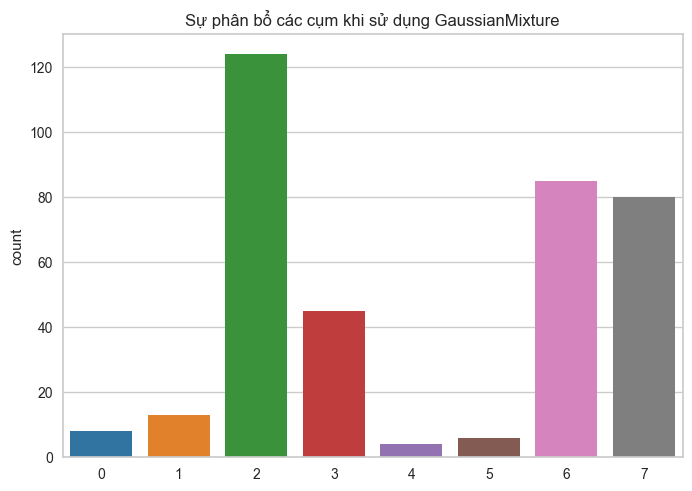

In [129]:
lgb_preds=0
for model in model_list2:
    lgb_preds+=model2.predict(df_new)
    
pl = sns.countplot(x=np.argmax(lgb_preds,axis=1), palette='tab10')
pl.set_title("Sự phân bổ các cụm khi sử dụng GaussianMixture")
plt.show()